In [1]:
import pandas as pd
import numpy as np

In [2]:
# TODO: use pd.read_csv("https://data-analysis.fedoraproject.org/csv-reports/countme/totals.csv", ...)

# Read totals.csv, indexed by week_start (and drop week_end)
totals = pd.read_csv("../totals.csv",
                     index_col='week_start', parse_dates=True,
                     usecols=lambda col: col not in ['week_end'])

# Convert week_start to a full weekly index, so we can look up arbitrary points in time and other fun things
totals.index = totals.index.to_period(freq='W').rename('week')

In [3]:
# OK! Let's say you don't care about what repos they're using, you just wanna know how many hosts we saw.
# Take your weekly totals, grouped by the host type, and take the count from the repo with the most hits.
hosttype = ['os_name', 'os_version', 'os_variant', 'os_arch', 'sys_age']
hosts = totals.groupby(['week']+hosttype).agg(hosts=('hits', max))

# Here's a little slice of the resulting data - September 21, Fedora 31 only:
hosts.loc[('2020-09-21', 'Fedora', '31'), :]

hosts
week                  os_name os_version os_variant  os_arch sys_age       
2020-09-21/2020-09-27 Fedora  31         generic     x86_64  1            3
                                                             3            6
                                                             4            1
                                         workstation x86_64  1            3
                                                             2            1
                                                             3            2

In [4]:
# We could also build it this way...

# First, pivot the table so we have rows for weekly totals by host type,
# with columns for each (repo_tag, repo_arch)
rt = totals.pivot_table(
    index=['week']+hosttype,
    columns=['repo_tag', 'repo_arch'], 
    values='hits', fill_value=0, aggfunc='max'
).sort_index() # groupby() sorts the index keys by default

# Now let's add two columns - 'all' for the total hits, and 'max' for the highest
(rt['all'], rt['max']) = rt.sum(axis=1), rt.max(axis=1)

# So now we have the same thing, but with lots of extra columns
rt.loc[('2020-09-21', 'Fedora', '31'), :]

repo_tag                                                             epel-8  \
repo_arch                                                            x86_64   
week                  os_name os_version os_variant  os_arch sys_age          
2020-09-21/2020-09-27 Fedora  31         generic     x86_64  1            0   
                                                             3            0   
                                                             4            0   
                                         workstation x86_64  1            0   
                                                             2            0   
                                                             3            0   

repo_tag                                                             epel-modular-8  \
repo_arch                                                                    x86_64   
week                  os_name os_version os_variant  os_arch sys_age                  
2020-09-21/2020-09-27 Fedora  31         generic     x86_64  1                    0   
                                                             3                    0   
                                                             4                    0   
                                         workstation x86_64  1                    0   
                                                             2                    0   
                                                             3                    0   

repo_tag                                                             fedora-20  \
repo_arch                                                               x86_64   
week                  os_name os_version os_variant  os_arch sys_age             
2020-09-21/2020-09-27 Fedora  31         generic     x86_64  1               0   
                                                             3               0   
                                                             4               0   
                                         workstation x86_64  1               0   
                                                             2               0   
                                                             3               0   

repo_tag                                                             fedora-21  \
repo_arch                                                               x86_64   
week                  os_name os_version os_variant  os_arch sys_age             
2020-09-21/2020-09-27 Fedora  31         generic     x86_64  1               0   
                                                             3               0   
                                                             4               0   
                                         workstation x86_64  1               0   
                                                             2               0   
                                                             3               0   

repo_tag                                                             fedora-22  \
repo_arch                                                               x86_64   
week                  os_name os_version os_variant  os_arch sys_age             
2020-09-21/2020-09-27 Fedora  31         generic     x86_64  1               0   
                                                             3               0   
                                                             4               0   
                                         workstation x86_64  1               0   
                                                             2               0   
                                                             3               0   

repo_tag                                                             fedora-23  \
repo_arch                                                               x86_64   
week                  os_name os_version os_variant  os_arch sys_age             
2020-09-21/2020-09-27 Fedora  31         

In [5]:
# And, as you'd hope, the ['max'] column has the same data as `hosts`
rt['max'].to_frame().rename(columns={'max':'hosts'}).equals(hosts)

True

In [6]:
# Let's take a subset that's just Fedora hosts..
fh = hosts.xs(level='os_name', key='Fedora')
# Take a peek at what we've got - .xs() drops the columm you used
fh.loc[('2020-09-21', '31'), :]

hosts
week                  os_version os_variant  os_arch sys_age       
2020-09-21/2020-09-27 31         generic     x86_64  1            3
                                                     3            6
                                                     4            1
                                 workstation x86_64  1            3
                                                     2            1
                                                     3            2

In [7]:
# You just wanna know how many hosts we have for each Fedora version over time?
# Okay, let's do that, and split it up by variant/arch..
fedver = fh.pivot_table(values='hosts', aggfunc=sum, fill_value=0,
                        index=['week', 'os_version'], columns=['os_variant', 'os_arch'])
# And then add a column that's the total of all the others.
fedver['All'] = fedver.sum(axis=1).astype(int)
# Here's a slice from the 21st of September again. Same count as above, just different columns.
fedver.loc[('2020-09-21', '31'), :]

os_variant                       cinnamon          cloud                    \
os_arch                           aarch64 x86_64 aarch64 arm ppc64le s390x   
week                  os_version                                             
2020-09-21/2020-09-27 31                0      0       0   0       0     0   

os_variant                              container             ...   soas  \
os_arch                          x86_64   aarch64 arm armhfp  ... x86_64   
week                  os_version                              ...          
2020-09-21/2020-09-27 31              0         0   0      0  ...      0   

os_variant                       workstation                             \
os_arch                              aarch64 armhfp i386 ppc64le x86_64   
week                  os_version                                          
2020-09-21/2020-09-27 31                   0      0    0       0      6   

os_variant                          xfce               All  
os_arch                          aarch64 armhfp x86_64      
week                  os_version                            
2020-09-21/2020-09-27 31               0      0      0  16  

[1 rows x 54 columns]

In [8]:
# Here's a table of the totals over time for every Fedora version..
fedver_totals = fedver['All'].unstack('os_version', fill_value=0)
fedver_totals

os_version,18.04,29,30,31,32,33,34,7,8,rawhide
week,,,,,,,,,,
2020-02-10/2020-02-16,0,0,0,5,267,463,0,0,0,0
2020-02-17/2020-02-23,0,0,0,10,1156,1345,0,0,0,0
2020-02-24/2020-03-01,0,0,0,9,2749,2329,0,0,0,0
2020-03-02/2020-03-08,0,0,0,12,3991,1962,0,0,0,0
2020-03-09/2020-03-15,0,0,0,15,5222,2253,0,0,0,0
2020-03-16/2020-03-22,0,0,0,21,10605,2532,0,0,0,0
2020-03-23/2020-03-29,0,0,0,16,12932,3336,0,0,0,0
2020-03-30/2020-04-05,0,0,0,20,15398,3124,0,0,0,0
2020-04-06/2020-04-12,0,0,0,18,16051,3335,0,0,0,0


<AxesSubplot:xlabel='week'>

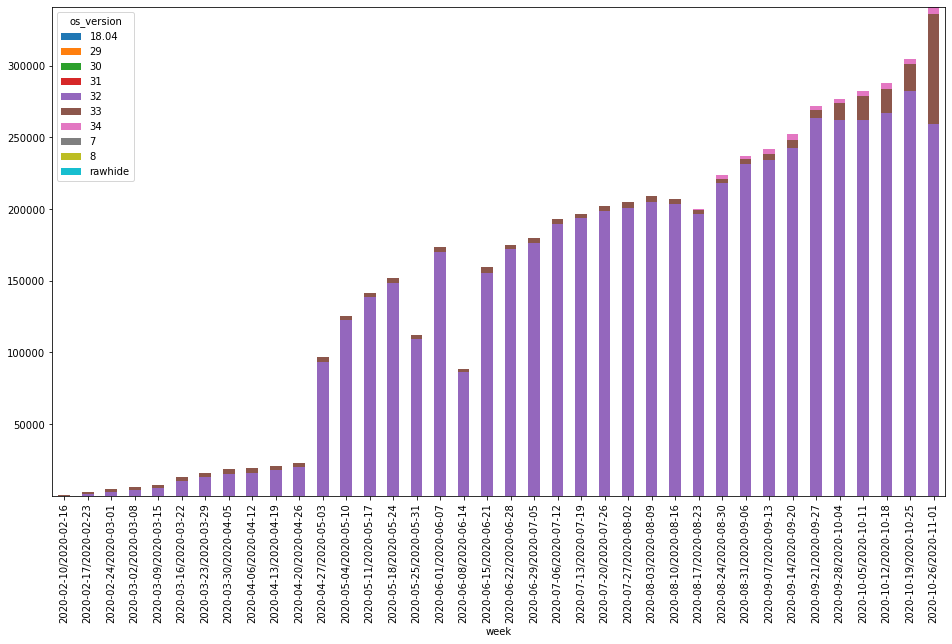

In [9]:
# And here's a stacked bar graph of that data!
fedver_totals.plot.bar(figsize=(16,9), stacked=True)